In [1]:
import gym
from model import ActorModel, CriticModel, Memory, PPO
import torch
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

cpu


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)


cpu


In [3]:
def run(n_epochs, gamma, clip_ratio, c1, games, fc_size, T, name):

    # create the environment from gym
    env = gym.make('CartPole-v1')
    observation_space = env.observation_space.shape[-1]
    action_space = env.action_space.n
    # create the model
    actor = ActorModel(observation_space, action_space, fc_size)
    critic = CriticModel(observation_space, fc_size)
    memory = Memory()
    ppo = PPO(memory, actor, critic)
    running_history = []
    results = {}
    reward_history = []
    wins = []
    losses = []
    step = 0
    
    save_path = os.path.join(os.curdir, 'saved_files/'+name+'.pickle')
    if not os.path.exists(os.path.join(os.curdir, 'saved_files')):
        os.mkdir(os.path.join(os.curdir, 'saved_files'))

    if os.path.exists(save_path):
        # load values
        with open(save_path, 'rb') as file2load:
            print('Loading previous values...')
            results = pickle.load(file2load)
            print('Values Loaded')
    else:
        ## main loop ##
        for g in range(games):
            # get initial state
            state = env.reset()
            # setup useful variables
            running_score = 0
            train_counter = 0
            done = False
            # iterate through the game util it's finished
            while not done:
                # env.render()
                act_distr = actor(torch.tensor(state, dtype=torch.float))
                action = np.argmax(np.random.multinomial(1, np.array(act_distr.data)))
                new_state, reward, done, info = env.step(action)
                step += 1
                # update running score
                running_score += reward
                # compute log_probs of the prob distribution
                log_prob = np.log(act_distr.data[action]).item()
                # compute the value for this game iteration
                value = critic(torch.tensor(state, dtype=torch.float)).data.item()
                # store the info in the memory
                memory.push(state, action, reward, value, done, log_prob)
                # update policy once every T steps
                if step % T == 0:
                    ppo(n_epochs, gamma, clip_ratio, c_1)
                    train_counter += 1
                # update current state to new state
                state = new_state
                running_history.append(running_score)
                # by documentation, the problem is solved
                # if the average reward is greater than 195 over the last 100 trials
                # let't check this
                if step % 100 == 0:
                    avg_reward = np.mean(running_history[-100:])
                    reward_history.append(avg_reward)
                    if avg_reward >= 195:
                        wins.append(avg_reward)
                    else:
                        losses.append(avg_reward)
                    print('Game completed: [{}]/[{}],'
                          ' Average reward of last 100 trials: {}'.format(g+1,
                                                                          games,
                                                                          avg_reward))
        print('Training Completed')
        file_name = name+'.pickle'
        print('Saving values...')
        results[name] = {'wins': wins, 'losses': losses, 'reward_history': reward_history}
        with open(os.path.join(os.curdir, 'saved_files/'+file_name), 'wb') as file2store:
            pickle.dump(results, file2store, protocol=pickle.HIGHEST_PROTOCOL)
        print('Done!')
    return results

In [4]:
# define some hyperparameters from the paper of PPO --> experiment 1
n_epochs = 10
gamma = 0.99
clip_ratio = 0.2
c_1 = 0.5
games = 1000
fc_size = 128
T = 2048
result_1 = run(n_epochs, gamma, clip_ratio, c_1, games, fc_size, T, name='Exp_1')

# define some hyperparameters from the paper of PPO --> experiment 2
n_epochs = 15
gamma = 0.99
clip_ratio = 0.2
c_1 = 0.5
games = 1000
fc_size = 128
T = 512
result_2 = run(n_epochs, gamma, clip_ratio, c_1, games, fc_size, T, name='Exp_2')

# define some hyperparameters from the paper of PPO --> experiment 3
n_epochs = 3
gamma = 0.99
clip_ratio = 0.15
c_1 = 0.5
games = 1000
fc_size = 128
T = 128
result_3 = run(n_epochs, gamma, clip_ratio, c_1, games, fc_size, T, name='Exp_3')

Loading previous values...
Values Loaded
Loading previous values...
Values Loaded
Loading previous values...
Values Loaded


In [5]:
def plot_image(exp_results, exp_name='Exp_1'):
    n_experiments = len(exp_results[exp_name]['reward_history'])
    plt.figure(figsize=(10, 6))
    plt.plot(exp_results[exp_name]['reward_history'][::10])
    plt.xscale('log')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('{} Results'.format(exp_name))

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

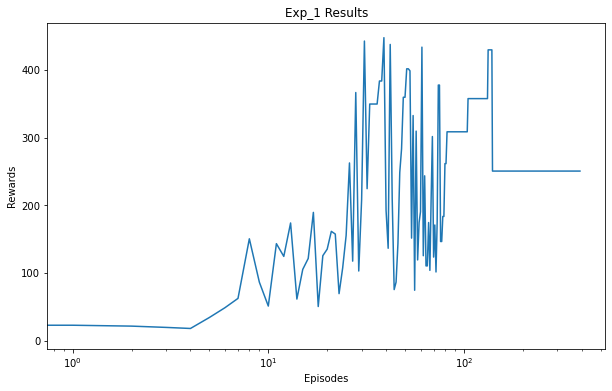

Wins: 2773, Losses: 1152


In [6]:
plot_image(result_1, exp_name='Exp_1')
print('Wins: {}, Losses: {}'.format(len(result_1['Exp_1']['wins']), len(result_1['Exp_1']['losses'])))

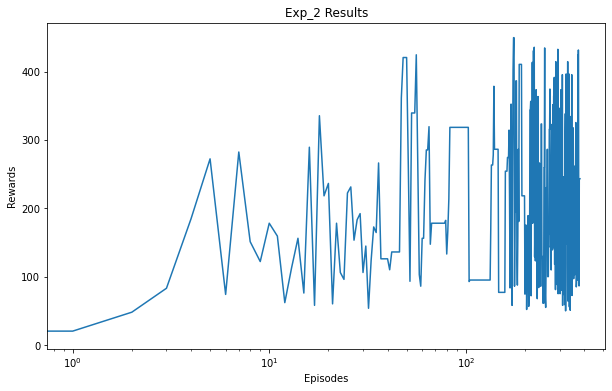

Wins: 1959, Losses: 1859


In [7]:
plot_image(result_2, exp_name='Exp_2')
print('Wins: {}, Losses: {}'.format(len(result_2['Exp_2']['wins']), len(result_2['Exp_2']['losses'])))

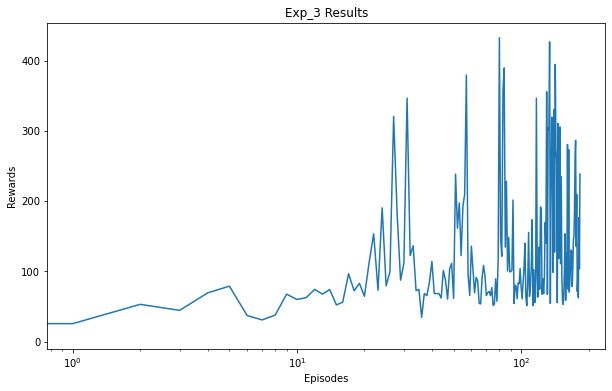

Wins: 318, Losses: 1519


In [8]:
plot_image(result_3, exp_name='Exp_3')
print('Wins: {}, Losses: {}'.format(len(result_3['Exp_3']['wins']), len(result_3['Exp_3']['losses'])))